**Please enable GPU accelerator to run this notebook**

In [1]:
# Basic packages
import numpy as np
import pandas as pd

# Evaluation Metricas
from sklearn.metrics import roc_curve, f1_score, recall_score, precision_score, plot_confusion_matrix, confusion_matrix, plot_roc_curve, auc, accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay as cmd

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# Models
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Hyperparameter Tuning
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV
# Saving work of hyperparameter tuning
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events


#Optuna for CatBoost Hyperparameter tuning
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import joblib


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit

# Encoders and Scaling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Models
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Encodings.
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Ensembling techniques
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Validations
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

# Evaluation metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import gc

from scipy import interp
import itertools
gc.enable()

## Commonly used functions

In [2]:
#Used to drop columns from the given list if they are present in the df.(inplace removal)
def dropCol(df, cols):
    for col in cols:
        if col in df.columns:
            df.drop(col, axis = 1, inplace = True)

# Removes column with Nan values greater than the threshold(given in the range of 0 to 1)
def removeColWithNan(df, threshold):
    removedCol = []
    for col in df:
        l1 = df[col].isna().sum()
        l2 = len(df)
        nanPercentage = (l1/l2)
        if nanPercentage >= threshold:
            if col in df.columns:
                df = df.drop(col, axis = 1)
                removedCol.append(col)
    return df, removedCol

# Return categorical and numerical columns in the dataframe.
def cat_and_num_colNames(df):
    categoricalCol = df.select_dtypes(include=['O', 'category']).columns
    numCol = df.select_dtypes(include=[np.number]).columns
    return categoricalCol, numCol


# Frequency encoding of the columns that are passed.
def frequencyEncoder(train, test, cols):
    for variable in cols:
        t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
        t = t.reset_index()
        t.loc[t[variable] == 1, 'level_0'] = np.nan
        t.set_index('index', inplace=True)
        max_label = t['level_0'].max() + 1
        t.fillna(max_label, inplace=True)
        frequency_encoder = t.to_dict()['level_0']
        train[variable] = train[variable].map(lambda x : frequency_encoder.get(x, np.nan))
        test[variable] = test[variable].map(lambda x : frequency_encoder.get(x, np.nan))
    return train, test

def labelEncoder(train, test, labelCol):
    enc = LabelEncoder()
    for col in labelCol:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        col_values = list(set(train[col].unique()) | set(test[col].unique()))
        enc.fit(col_values)
        train[col] = enc.transform(train[col])
        test[col] = enc.transform(test[col])
    return train, test



def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def uncorrelated_features(df, threshold=0.9):
    """
    Returns a subset of df columns with Pearson correlations
    below threshold.
    """

    corr = df.corr().abs()
    keep = []
    for i in range(len(corr.iloc[:,0])):
        above = corr.iloc[:i,i]
        if len(keep) > 0: above = above[keep]
        if len(above[above < threshold]) == len(above):
            keep.append(corr.columns.values[i])

    return df[keep]

# Data and Memory 
    This sections contains:
    1. Get the data as pandas DataFrame.
    2. Observe each column and choose the optimal datatype to reduce memory consumption.
    3. Merge the 2 tables provided on TransactionID.

In [3]:
train_tran_full = pd.read_csv('../input/frauddetect/train_transaction.csv')
test_tran_full = pd.read_csv('../input/frauddetect/test_transaction.csv')
train_id_full = pd.read_csv('../input/frauddetect/train_identity.csv')
test_id_full = pd.read_csv('../input/frauddetect/test_identity.csv')

In [4]:
%%time
train_tran = reduce_mem_usage(train_tran_full)
del train_tran_full
test_tran = reduce_mem_usage(test_tran_full)
del test_tran_full
train_id = reduce_mem_usage(train_id_full)
del train_id_full
test_id = reduce_mem_usage(test_id_full)
del test_id_full


Mem. usage decreased to 318.65 Mb (70.1% reduction)
Mem. usage decreased to 215.36 Mb (69.6% reduction)
Mem. usage decreased to 15.59 Mb (42.7% reduction)
Mem. usage decreased to 10.27 Mb (42.7% reduction)
CPU times: user 40.9 s, sys: 58.7 s, total: 1min 39s
Wall time: 1min 40s


In [5]:
train =  pd.merge(train_tran, train_id, on = 'TransactionID', how = 'left', suffixes = ("", ""));
test = pd.merge(test_tran, test_id, on = 'TransactionID', how = 'left', suffixes = ("", ""))
adversarial_features = ["TransactionID"]
train = train.drop(adversarial_features, axis = 1)
test = test.drop(adversarial_features, axis = 1)
del train_tran
del test_tran
del train_id
del test_id

# EDA
    This section contains EDA done which are primarily very important and finally used in the submission. All the other EDA's are present in the EDA notebook.

Time line distribution of train and test
       
       To see how the train and test is distributed across time. This diagram gives a lot of insight into whether the problem 
       can be modelled as time series, whether post processing can be used on the data.

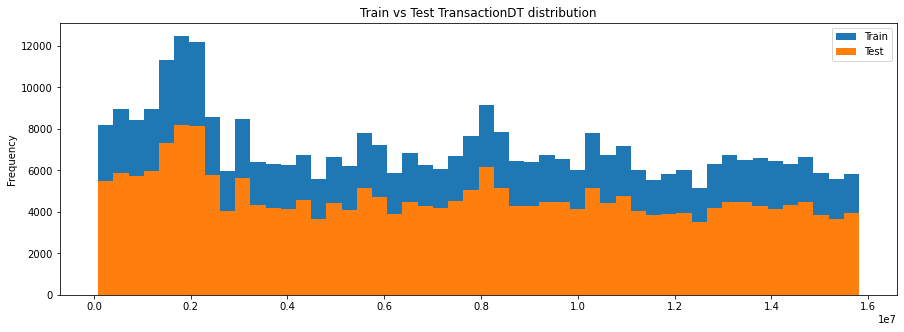

In [6]:
    train['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='Train', bins=50,
                                        title='Train vs Test TransactionDT distribution')
    test['TransactionDT'].plot(kind='hist', label='Test', bins=50)
    plt.legend()
    plt.savefig('time_line.jpg', bbox_inches='tight') 
    plt.show()

EDA 2 : 
    
        To see the imbalance percentage in the data. 

0.036444210433943226% minority class


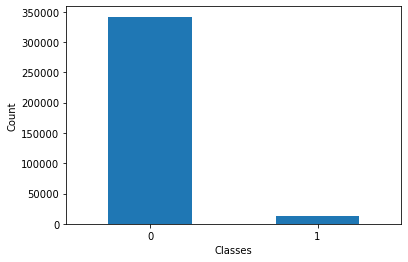

In [7]:
print(str(len(train[train['isFraud'] == 1])/len(train[train['isFraud'] == 0])) + "% minority class")
plot = train['isFraud'].value_counts().plot.bar(rot = 0)
plot.set_xlabel("Classes")
plot.set_ylabel("Count")
fig = plot.get_figure()
fig.savefig("class_imb.jpg", bbox_inches='tight') # Uncomment to save this plot as jpg image.

### Cardinality Reduction of some categorical variables:
        The theory behind Category Cardinality Reduction has been explained in the report.
        It has been applied on these features.
        1. R_emaildomain
        2. P_emaildomain
        3. Device_Info
        Basic Algorithm is as follows:
            Look at the categories. If many categories have very similar target distribution, merge them into a single category.

1. P_emaildomain

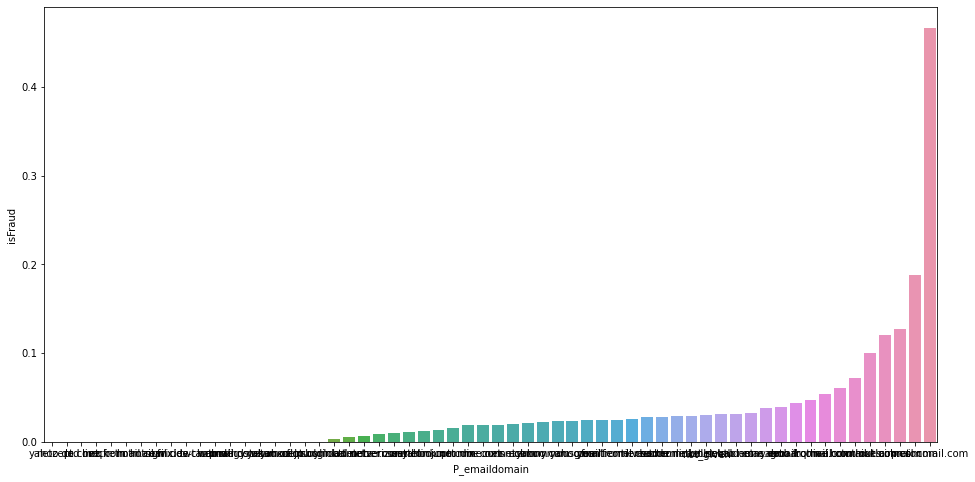

In [8]:
train['P_emaildomain'].fillna('not_given', inplace = True)
groupedData = train[['P_emaildomain', 'isFraud']].groupby(by = 'P_emaildomain', as_index = False).mean().sort_values(by = 'isFraud', ascending = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = groupedData['P_emaildomain'], y = groupedData['isFraud'])

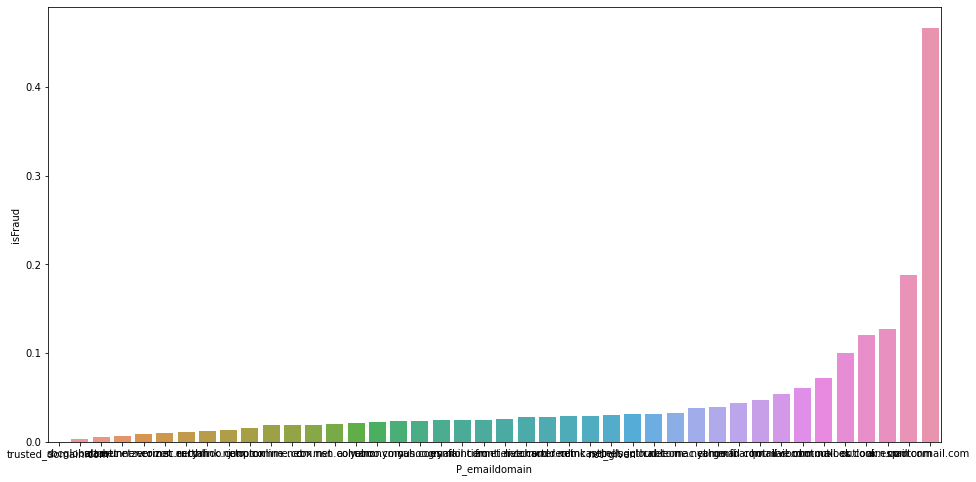

In [9]:
trusted_domains = []
for index, row in groupedData.iterrows():
    if(row['isFraud'] == 0):
        trusted_domains.append(row['P_emaildomain'])

mapping = {}
for col in train['P_emaildomain'].unique():
    if col in trusted_domains:
        mapping[col] = "trusted_domain.com"
    else:
        mapping[col] = col

train['P_emaildomain'] = train['P_emaildomain'].map(mapping)

groupedData = train[['P_emaildomain', 'isFraud']].groupby(by = 'P_emaildomain', as_index = False).mean().sort_values(by = 'isFraud', ascending = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = groupedData['P_emaildomain'], y = groupedData['isFraud'])

There were many P_emaildomains with 0 fraud rate, these have been combined into a single trusted domain category

2. R_emaildomain

In [10]:
train['R_emaildomain'].fillna('not_given', inplace = True)
groupedData = train[['R_emaildomain', 'isFraud']].groupby(by = 'R_emaildomain', as_index = False).mean().sort_values(by = 'isFraud', ascending = True)
plt.figure(figsize = (16, 8))
# sns.barplot(x = groupedData['R_emaildomain'], y = groupedData['isFraud'])

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [11]:
trusted_domains = []
for index, row in groupedData.iterrows():
    if(row['isFraud'] == 0):
        trusted_domains.append(row['R_emaildomain'])
mapping = {}
for col in train['R_emaildomain'].unique():
    if col in trusted_domains:
        mapping[col] = "trusted_domain.com"
    else:
        mapping[col] = col

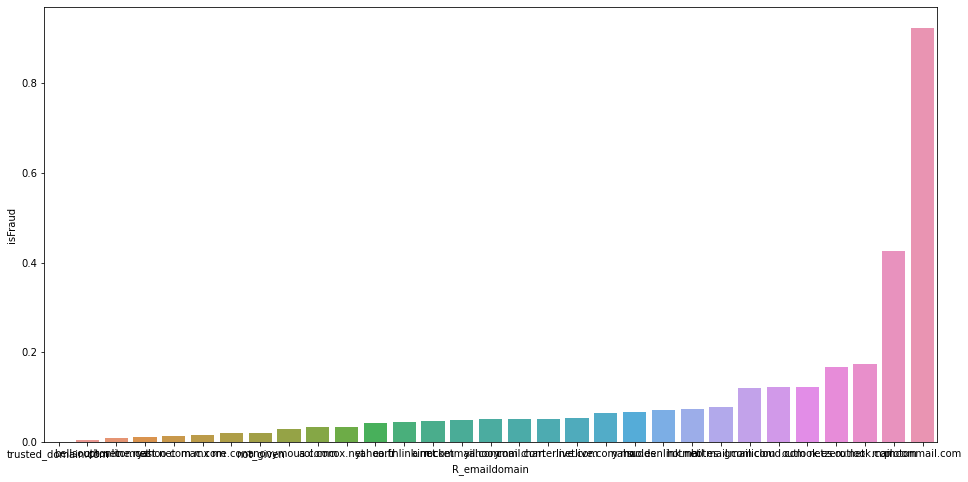

In [12]:
train['R_emaildomain'] = train['R_emaildomain'].map(mapping)
groupedData = train[['R_emaildomain', 'isFraud']].groupby(by = 'R_emaildomain', as_index = False).mean().sort_values(by = 'isFraud', ascending = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = groupedData['R_emaildomain'], y = groupedData['isFraud'])

We see that the number of categories has decreased.

3. DeviceInfo

In [13]:
groupedData = train[['DeviceInfo', 'isFraud']].groupby(by = 'DeviceInfo', as_index = False).mean().sort_values(by = 'isFraud', ascending = True)
trusted_devices = []
fraudulent_devices = []
for index, row in groupedData.iterrows():
    if(row['isFraud'] <= 0.1):
        trusted_devices.append(row['DeviceInfo'])
    elif row['isFraud'] >= 0.9:
        fraudulent_devices.append(row['DeviceInfo'])

mapping = {}
for col in train['DeviceInfo'].unique():
    if col in trusted_devices:
        mapping[col] = "trusted_device"
    elif col in fraudulent_devices:
        mapping[col] = "fradulent_device"
    else:
        mapping[col] = col

train['DeviceInfo'] = train['DeviceInfo'].map(mapping)

In [14]:
ytrain = train['isFraud']
train.drop('isFraud', axis = 1, inplace = True)
xtrain = train.copy()
del train

### Correlation Check

In [15]:
def uncorrelated_features(df, threshold=0.9):
    """
    Returns a subset of df columns with Pearson correlations
    below threshold.
    """

    corr = df.corr().abs()
    keep = []
    for i in range(len(corr.iloc[:,0])):
        above = corr.iloc[:i,i]
        if len(keep) > 0: above = above[keep]
        if len(above[above < threshold]) == len(above):
            keep.append(corr.columns.values[i])

    return df[keep]

def uncorr_columns(data, columns_to_check, threshold = 0.9):
    uncorr_data = uncorrelated_features(data, threshold)
    
    data = data.drop(columns = columns_to_check)
    data[uncorr_data.columns] = uncorr_data.values
    
    print('removed columns:'),
    for i in columns_to_check:
        if i not in uncorr_data.columns:
            print(i),

    return uncorr_data, uncorr_data.columns

### Principle Component Analysis

In [16]:
def pca_columns(data, columns_to_pca, principal_components, name, plot = False):
    data.loc[:, columns_to_pca] = data.fillna(-999)
    data.loc[:, columns_to_pca] = StandardScaler().fit_transform(data.loc[:, columns_to_pca])
    
    if(plot):
        tune_pca = PCA(n_components = len(data.loc[:, columns_to_pca].columns))
        tune_pca_fit_train_v = tune_pca.fit_transform(data.loc[:, columns_to_pca])
        plt.plot(tune_pca.explained_variance_ratio_.cumsum())
        plt.xlabel('Number of components')
        plt.ylabel('Variance percentage captured')
        plt.title('Principle Component Analysis')
        plt.savefig('pca.jpg', bbox_inches='tight')
        plt.show()

    pca = PCA(n_components = principal_components)
    pca_fit_train_v = pca.fit_transform(data.loc[:, columns_to_pca])
    
    column_names = [name + '_']*principal_components
    for i in range(principal_components):
        column_names[i] = column_names[i]+str(i+1)

    new_pca_columns = pd.DataFrame(data = pca_fit_train_v)
    new_pca_columns.columns = column_names
    
    data = data.drop(columns = columns_to_pca)    
    data[column_names] = new_pca_columns.values
    
    return data, column_names

In [17]:
def reduce_columns(data, columns_to_reduce, principal_components, name, method = 'pca', threshold = 0.9, plot = False, disp = False):
    cat_cols, columns_to_reduce = cat_and_num_colNames(data[columns_to_reduce])
    del cat_cols
    
    if method=='uncorrelated':
        data, relevant_columns = uncorr_columns(data, columns_to_reduce, threshold)
        if(disp):
            display(data[required_columns])
        
    elif method=='pca':
        data, relevant_columns = pca_columns(data, columns_to_reduce, principal_components, name, plot)
        if(disp):
            display(data[relevant_columns])
    
    return data

V Columns

In [18]:
%%time
# xtrain = reduce_columns(xtrain, xtrain.loc[:, 'V1':'V339'].columns, 45, 'V', plot=True, disp = False, method = 'pca', threshold = 0.95)
# test = reduce_columns(test, test.loc[:, 'V1':'V339'].columns, 45, 'V', method = 'uncorrelated', threshold = 0.95)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


ID Columns

In [20]:
%%time
# xtrain = reduce_columns(xtrain, xtrain.loc[:, 'id_01':'id_32'].columns, 9, 'ID', plot=True)
# test = reduce_columns(test, test.loc[:, 'id_01':'id_32'].columns, 9, 'ID')

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 6.2 µs


# Feature Generation

Card columns
    
    Add explanation here

In [21]:
card_cols = [col for col in xtrain if col.startswith('card')]
for col in card_cols:
    xtrain[str(col) + str("_full")] = xtrain[col].map(pd.concat([xtrain[col], test[col]], ignore_index = True).value_counts(dropna = False))
    test[str(col) + str("_full")] = test[col].map(pd.concat([xtrain[col], test[col]], ignore_index = True).value_counts(dropna = False))
    

In [22]:
for col in card_cols:
    xtrain[str("TransactionAmt_mean_") + str(col)] = xtrain['TransactionAmt'] / xtrain.groupby([col])['TransactionAmt'].transform('mean')
    test[str("TransactionAmt_mean_") + str(col)] = test['TransactionAmt'] / test.groupby([col])['TransactionAmt'].transform('mean')

### Unique Card/User Identification

In [23]:
xtrain['reference_day'] = np.floor(xtrain['TransactionDT']/(3600*24)) + 650
test['reference_day'] = np.floor(test['TransactionDT']/(3600*24)) + 650

In [24]:
xtrain['First_Credit_Trans'] = xtrain['reference_day'] - xtrain['D1']
test['First_Credit_Trans'] = test['reference_day'] - test['D1']

In [25]:
# userid_cols = ['card1','card2','card3', 'card4','card5','card6','addr1','addr2','First_Credit_Trans','P_emaildomain']
userid_cols = ['First_Credit_Trans', 'card1', 'addr1']

In [26]:
xtrain['userid'] = xtrain[userid_cols[0]]
for i in range(1, len(userid_cols)):
    xtrain['userid'] = xtrain['userid'].astype(str) + '_' + xtrain[userid_cols[i]].astype(str)

test['userid'] = test[userid_cols[0]]
for i in range(1, len(userid_cols)):
    test['userid'] = test['userid'].astype(str) + '_' + xtrain[userid_cols[i]].astype(str)

In [27]:
xtrain['isFraud'] = ytrain
xtrain['isFraud'] = xtrain['isFraud'].apply(pd.to_numeric)

In [28]:
unique_cards_train = set(xtrain['userid'])
unique_cards_test = set(test['userid'])
common_cards = unique_cards_train.intersection(unique_cards_test)

In [29]:
total_known_users = 0
for user in test['userid']:
    if user in common_cards:
        total_known_users += 1
print(total_known_users)
total_known_users/len(test)

60974


0.25812815389304705

In [30]:
print(len(xtrain))
len(unique_cards_train)

354324


160677

In [31]:
print(len(test))
len(unique_cards_test)

236216


187602

In [32]:
len(common_cards)

29643

In [33]:
user_info_train = pd.DataFrame(xtrain['userid'])
user_info_test = pd.DataFrame(test['userid'])

In [34]:
# xtrain['Transaction_DoW'] = np.floor((xtrain['TransactionDT']/(60*60*24)-1)%7)
# test['Transaction_DoW'] = np.floor((test['TransactionDT']/(60*60*24) - 1) % 7)

# xtrain['Transaction_hour'] = np.floor(xtrain['TransactionDT']/(60*60))%24
# test['Transaction_hour'] = np.floor(test['TransactionDT']/(60*60))%24

In [35]:
# for i in xtrain.loc[:, 'D1':'D15'].columns:
#     xtrain[i+'_new'] = xtrain['reference_day'] - xtrain[i]
#     test[i+'_new'] = test['reference_day'] - test[i]

In [36]:
# def encode_AG(main_columns, userids, aggregations=['mean'], train_df=xtrain, test_df=test, fillna=True, usena=False):
#     for main_column in main_columns:  
#         for col in userids:
#             for agg_type in aggregations:
#                 new_col_name = main_column+'_'+col+'_'+agg_type
#                 temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
#                 if usena: temp_df.loc[temp_df[main_column]==-9999,main_column] = np.nan
#                 temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
#                                                         columns={agg_type: new_col_name})

#                 temp_df.index = list(temp_df[col])
#                 temp_df = temp_df[new_col_name].to_dict()   

#                 train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
#                 test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
#                 if fillna:
#                     train_df[new_col_name].fillna(-9999,inplace=True)
#                     test_df[new_col_name].fillna(-9999,inplace=True)
                
#                 print("'"+new_col_name+"'",', ',end='')

# def encode_AG2(main_columns, userids, train_df=xtrain, test_df=test):
#     for main_column in main_columns:  
#         for col in userids:
#             comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
#             mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
#             train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
#             test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
#             print(col+'_'+main_column+'_ct, ',end='')

In [37]:
# encode_AG(['D4_new','D10_new','D15_new'],['userid'],['mean','std'])
# encode_AG(['TransactionAmt','dist1'],['userid'],['mean','std'])
# encode_AG2(['C13'], ['userid'])

In [38]:
# encode_AG(['TransactionAmt','D4','D9','D10','D15'],['userid'],['mean','std'],fillna=True,usena=True)
# encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['userid'],['mean'],xtrain,test,fillna=True,usena=True)
# # AGGREGATE
# encode_AG2(['P_emaildomain','dist1','id_02'], ['userid'], train_df=xtrain, test_df=test)
# encode_AG(['C14'],['userid'],['std'],fillna=True,usena=True)
# encode_AG2(['C13'], ['userid'], train_df=xtrain, test_df=test) 
# encode_AG2(['V' + str(x) for x in range(1,14)], ['userid'], train_df=xtrain, test_df=test)


In [39]:
dropCol(xtrain, ['isFraud', 'TransactionDT', 'userid', 'TransactionID'])
dropCol(test, ['isFraud', 'TransactionDT', 'userid', 'TransactionID'])

### Encoding

In [40]:
cat_cols, num_cols = cat_and_num_colNames(xtrain)
one_hot_encode_cols = []
freq_encode_cols = []
label_encode_cols = []
for col in cat_cols:
    len_uniq = xtrain[col].nunique()
    if len_uniq > 1000:
        freq_encode_cols.append(col)
    else:
        label_encode_cols.append(col)

In [41]:
%%time
xtrain, test = labelEncoder(xtrain, test, label_encode_cols)
xtrain, test = frequencyEncoder(xtrain, test, freq_encode_cols)
xtrain, test = labelEncoder(xtrain, test, one_hot_encode_cols)

CPU times: user 14.1 s, sys: 1.33 s, total: 15.4 s
Wall time: 15.5 s


# Hyper parameter tuning

### XGBoost Hyperparameter tuning : **Bayesian Optimization**
    BayesianOptimization library used for tuning
    Objective function is set based on the competition evaluation scheme.
    The domain space of each of the parameters is set large initially and then fine tuned based on model performance.

In [42]:
%%time
def bayes_parameter_opt_xgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6, output_process=False):
    # prepare data
    train_data = xgb.DMatrix(data=X, label=y)
    # parameters
    def xgb_objective(eta, min_child_weight, max_depth, gamma, subsample, colsample_bytree, scale_pos_weight, num_leaves, reg_alpha, reg_lambda, min_child_samples, 
                          feature_fraction, bagging_fraction):
        params = {}
        
        params['objective'] = 'binary:logistic'
        
        params['eval_metric'] = 'auc'
        params['eta'] = eta
        params["min_child_weight"] = int(round(min_child_weight))
        params['max_depth'] = int(max_depth)
        params['gamma'] = gamma
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree       
        params['scale_pos_weight'] = scale_pos_weight
        params['max_leaves'] = int(num_leaves)
        params['alpha'] = reg_alpha # alpha is alias for reg_alpha
        params['lambda'] = reg_lambda # lamda is alias for reg_lamda ( l2 regularization)
        cv_result = xgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=False, verbose_eval = 0, metrics=['auc'], early_stopping_rounds = 200)
        return max(cv_result['test-auc-mean'])
    xgbBO = BayesianOptimization(xgb_objective, {
                    'eta': (0.01, 0.1),
                    'min_child_weight': (1, 10),
                    'max_depth': (3, 13),
                    'gamma': (0.01, 0.),
                    'subsample': (0.1, 0.9),
                    'colsample_bytree': (0.1, 1.0),
                    'scale_pos_weight' : (1, 20),
                    'num_leaves' : (20, 250),
                    'reg_alpha' : (0.01, 0.3),
                    'reg_lambda' : (0.01, 0.3),
                    'min_child_samples' : (100, 250),
                    'feature_fraction' : (0.3, 0.8),
                    'bagging_fraction' : (0.3, 0.8),
                })
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    model_auc=[]
    for model in range(len(xgbBO.res)):
        model_auc.append(xgbBO.res[model]['target'])
    return xgbBO.res[pd.Series(model_auc).idxmax()]['target'],xgbBO.res[pd.Series(model_auc).idxmax()]['params']
opt_params = bayes_parameter_opt_xgb(xtrain, ytrain, init_round = 5, opt_round = 10, n_folds = 5, random_seed=6)

|   iter    |  target   | baggin... | colsam... |    eta    | featur... |   gamma   | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8399   |  0.7641   |  0.913    |  0.06681  |  0.4921   |  0.005729 |  3.959    |  137.5    |  9.982    |  193.9    |  0.2745   |  0.1458   |  8.493    |  0.5324   |
|  2        |  0.886    |  0.3377   |  0.8017   |  0.09182  |  0.5191   |  0.003867 |  10.42    |  197.3    |  2.588    |  94.97    |  0.2606   |  0.08     |  16.38    |  0.1221   |
|  3        |  0.8972   |  0.7828   |  0.6182   |  0.0168   |  0.7034   |  0.009269 |  11.58    |  140.2    |  6.334    |  22.76    |  0.2629   |  0.04415  |  7.486    |  0.8204   |
|  4        |  0.883    |  0.4553   |  0.1994   |  0.09568  |  0.335    |  0.001232 |  10.

### Catboost Hyperparameter tuning
    Running optuna (Bayesian Optimization based library) to obtain optimal set of hyperparameters and visualize the study/hyperparameter tuning

In [43]:
%%time
def objective(trial: Trial, x_train, y_train) -> float:
    
    param = {
            'learning_rate': trial.suggest_discrete_uniform('learning_rate', 0.05, 0.5, 0.025),
            'depth': trial.suggest_int('depth', 3, 8),
            'bagging_temperature': trial.suggest_int('bagging_temperature', 5, 10),
            'iterations': trial.suggest_int('iterations', 300, 1000),
            'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
            'border_count': trial.suggest_int('border_count', 1, 255),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30),
            'scale_pos_weight': trial.suggest_discrete_uniform('scale_pos_weight', 0.01, 1, 0.02),
            }
    
    catboost_model = CatBoostClassifier(task_type = 'GPU', **param, thread_count = 2, verbose = False)
    catboost_model.fit(x_train, y_train, cat_features = ['P_emaildomain', 'R_emaildomain', 'DeviceInfo', 'DeviceType'])
    print(param)
    
    cv = cross_val_score(catboost_model, x_train, y_train, scoring="roc_auc", cv = 5).mean()

    return cv

def optuna_catboost_gpu(x_train, y_train):
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(lambda trial : objective(trial, x_train, y_train), n_trials= 10)
    
#     joblib.dump(study, 'studyf.pkl')
#     pickle.dump(study, 'study_f.pkl')
    print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
    
    hist = study.trials_dataframe()
    display(hist.head())
    
    optuna.visualization.plot_optimization_history(study)
    optuna.visualization.plot_slice(study)
    optuna.visualization.plot_parallel_coordinate(study)
    optuna.visualization.plot_contour(study)
optuna_catboost_gpu(xtrain, ytrain)

[I 2020-12-20 12:46:24,361] A new study created in memory with name: no-name-943d029a-a92e-45f2-8307-cfd3a5cfada8
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.15000000000000002, 'depth': 6, 'bagging_temperature': 8, 'iterations': 852, 'random_strength': 8.625085839931027e-08, 'border_count': 56, 'l2_leaf_reg': 25, 'scale_pos_weight': 0.99}


[I 2020-12-20 12:52:50,179] Trial 0 finished with value: 0.8915787585644163 and parameters: {'learning_rate': 0.15000000000000002, 'depth': 6, 'bagging_temperature': 8, 'iterations': 852, 'random_strength': 8.625085839931027e-08, 'border_count': 56, 'l2_leaf_reg': 25, 'scale_pos_weight': 0.99}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.325, 'depth': 4, 'bagging_temperature': 9, 'iterations': 730, 'random_strength': 8.326562041972122e-08, 'border_count': 75, 'l2_leaf_reg': 5, 'scale_pos_weight': 0.77}


[I 2020-12-20 12:57:43,778] Trial 1 finished with value: 0.8795991568092087 and parameters: {'learning_rate': 0.325, 'depth': 4, 'bagging_temperature': 9, 'iterations': 730, 'random_strength': 8.326562041972122e-08, 'border_count': 75, 'l2_leaf_reg': 5, 'scale_pos_weight': 0.77}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.45, 'depth': 7, 'bagging_temperature': 9, 'iterations': 947, 'random_strength': 2.9467105678831915e-06, 'border_count': 29, 'l2_leaf_reg': 3, 'scale_pos_weight': 0.17}


[I 2020-12-20 13:03:25,350] Trial 2 finished with value: 0.8892518015589139 and parameters: {'learning_rate': 0.45, 'depth': 7, 'bagging_temperature': 9, 'iterations': 947, 'random_strength': 2.9467105678831915e-06, 'border_count': 29, 'l2_leaf_reg': 3, 'scale_pos_weight': 0.17}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.25, 'depth': 7, 'bagging_temperature': 10, 'iterations': 316, 'random_strength': 0.002325256458645393, 'border_count': 211, 'l2_leaf_reg': 29, 'scale_pos_weight': 0.39}


[I 2020-12-20 13:08:04,256] Trial 3 finished with value: 0.8704659217492147 and parameters: {'learning_rate': 0.25, 'depth': 7, 'bagging_temperature': 10, 'iterations': 316, 'random_strength': 0.002325256458645393, 'border_count': 211, 'l2_leaf_reg': 29, 'scale_pos_weight': 0.39}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.35000000000000003, 'depth': 7, 'bagging_temperature': 9, 'iterations': 951, 'random_strength': 7.511074028265633e-06, 'border_count': 68, 'l2_leaf_reg': 28, 'scale_pos_weight': 0.09}


[I 2020-12-20 13:13:53,804] Trial 4 finished with value: 0.8904073484250962 and parameters: {'learning_rate': 0.35000000000000003, 'depth': 7, 'bagging_temperature': 9, 'iterations': 951, 'random_strength': 7.511074028265633e-06, 'border_count': 68, 'l2_leaf_reg': 28, 'scale_pos_weight': 0.09}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.4, 'depth': 3, 'bagging_temperature': 7, 'iterations': 600, 'random_strength': 2.4378103210191986e-05, 'border_count': 211, 'l2_leaf_reg': 29, 'scale_pos_weight': 0.59}


[I 2020-12-20 13:18:33,741] Trial 5 finished with value: 0.8714798206778752 and parameters: {'learning_rate': 0.4, 'depth': 3, 'bagging_temperature': 7, 'iterations': 600, 'random_strength': 2.4378103210191986e-05, 'border_count': 211, 'l2_leaf_reg': 29, 'scale_pos_weight': 0.59}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.125, 'depth': 8, 'bagging_temperature': 8, 'iterations': 670, 'random_strength': 3.0360979883828208e-09, 'border_count': 204, 'l2_leaf_reg': 7, 'scale_pos_weight': 0.09}


[I 2020-12-20 13:24:22,430] Trial 6 finished with value: 0.8768555487342173 and parameters: {'learning_rate': 0.125, 'depth': 8, 'bagging_temperature': 8, 'iterations': 670, 'random_strength': 3.0360979883828208e-09, 'border_count': 204, 'l2_leaf_reg': 7, 'scale_pos_weight': 0.09}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.47500000000000003, 'depth': 4, 'bagging_temperature': 10, 'iterations': 897, 'random_strength': 0.259636675790486, 'border_count': 227, 'l2_leaf_reg': 22, 'scale_pos_weight': 0.45}


[I 2020-12-20 13:29:36,271] Trial 7 finished with value: 0.8795515290914647 and parameters: {'learning_rate': 0.47500000000000003, 'depth': 4, 'bagging_temperature': 10, 'iterations': 897, 'random_strength': 0.259636675790486, 'border_count': 227, 'l2_leaf_reg': 22, 'scale_pos_weight': 0.45}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.22500000000000003, 'depth': 4, 'bagging_temperature': 7, 'iterations': 510, 'random_strength': 0.0013213755611757047, 'border_count': 154, 'l2_leaf_reg': 17, 'scale_pos_weight': 0.33}


[I 2020-12-20 13:34:16,387] Trial 8 finished with value: 0.872875690581569 and parameters: {'learning_rate': 0.22500000000000003, 'depth': 4, 'bagging_temperature': 7, 'iterations': 510, 'random_strength': 0.0013213755611757047, 'border_count': 154, 'l2_leaf_reg': 17, 'scale_pos_weight': 0.33}. Best is trial 0 with value: 0.8915787585644163.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:554: UserWarning: The distribution is specified by [0.01, 1] and q=0.02, but the range is not divisible by `q`. It will be replaced by [0.01, 0.99].
  low=low, old_high=old_high, high=high, step=q


{'learning_rate': 0.4, 'depth': 6, 'bagging_temperature': 6, 'iterations': 645, 'random_strength': 0.6853555879648899, 'border_count': 173, 'l2_leaf_reg': 7, 'scale_pos_weight': 0.61}


[I 2020-12-20 13:39:25,347] Trial 9 finished with value: 0.8875868500139648 and parameters: {'learning_rate': 0.4, 'depth': 6, 'bagging_temperature': 6, 'iterations': 645, 'random_strength': 0.6853555879648899, 'border_count': 173, 'l2_leaf_reg': 7, 'scale_pos_weight': 0.61}. Best is trial 0 with value: 0.8915787585644163.


Best trial: score 0.8915787585644163,
params {'learning_rate': 0.15000000000000002, 'depth': 6, 'bagging_temperature': 8, 'iterations': 852, 'random_strength': 8.625085839931027e-08, 'border_count': 56, 'l2_leaf_reg': 25, 'scale_pos_weight': 0.99}


,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_random_strength,params_scale_pos_weight,state
0,0,0.891579,2020-12-20 12:46:24.364706,2020-12-20 12:52:50.178727,0 days 00:06:25.814021,8,56,6,852,25,0.150,8.625086e-08,0.99,COMPLETE
1,1,0.879599,2020-12-20 12:52:50.188165,2020-12-20 12:57:43.777561,0 days 00:04:53.589396,9,75,4,730,5,0.325,8.326562e-08,0.77,COMPLETE
2,2,0.889252,2020-12-20 12:57:43.779013,2020-12-20 13:03:25.350379,0 days 00:05:41.571366,9,29,7,947,3,0.450,2.946711e-06,0.17,COMPLETE
3,3,0.870466,2020-12-20 13:03:25.351921,2020-12-20 13:08:04.255906,0 days 00:04:38.903985,10,211,7,316,29,0.250,2.325256e-03,0.39,COMPLETE
4,4,0.890407,2020-12-20 13:08:04.257483,2020-12-20 13:13:53.803722,0 days 00:05:49.546239,9,68,7,951,28,0.350,7.511074e-06,0.09,COMPLETE


CPU times: user 56min 55s, sys: 5min 26s, total: 1h 2min 21s
Wall time: 53min 3s


# Validation and Model Training

### XGBoost Training
    The following two cells contains variable initializations, plot and validation code required to train XGBoost model. 
    The parameters are set based on the results obtained from the BayesianOptimization library.

In [45]:
oof_xgb = np.zeros(len(xtrain))
xgb_main_features = []
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
target = 'isFraud'
train = xtrain.copy()
train['isFraud'] = ytrain

ROC accuracy: 0.9655560834586064
ROC accuracy: 0.9588435814277521
ROC accuracy: 0.9629441914777117
ROC accuracy: 0.9636242660403543
ROC accuracy: 0.9628368795500521

CV roc score        : 0.9628, std: 0.0022. 
CV accuracy score   : 0.9868, std: 0.0003. 
CV recall score     : 0.7029, std: 0.0075. 
CV precision score  : 0.9000, std: 0.0051. 
CV f1 score         : 0.7893, std: 0.0060.


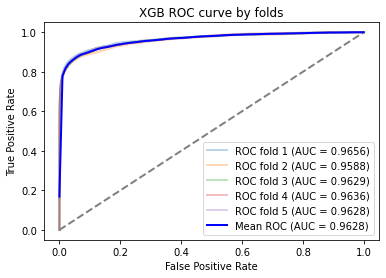

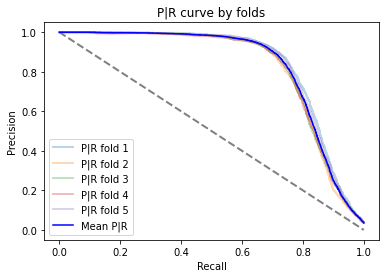

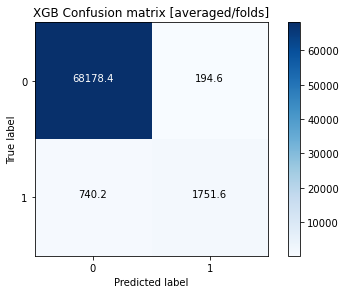

In [46]:
sample_submission = pd.read_csv('../input/frauddetect/sample_submission.csv')
xgb_submission=sample_submission.copy()
xgb_submission['isFraud'] = 0
n_fold = 5
i = 1
folds = KFold(n_splits=n_fold,shuffle=True)
for fold_n, (train_index, valid_index) in enumerate(folds.split(xtrain)):
    xgbclf = xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=9,
        learning_rate=0.048,
        subsample=0.85,
        colsample_bytree=0.85,
        scale_pos_weight = 10,
        missing=-999,
        tree_method='gpu_hist',
        reg_alpha=0.15,
        reg_lambda =0.85
    )
    
    X_train_, X_valid = xtrain.iloc[train_index], xtrain.iloc[valid_index]
    y_train_, y_valid = ytrain.iloc[train_index], ytrain.iloc[valid_index]
    xgbclf.fit(X_train_,y_train_)
    
    pred=xgbclf.predict_proba(test)[:,1]
    val=xgbclf.predict_proba(X_valid)[:,1]
    oof_xgb[valid_index] = xgbclf.predict_proba(X_valid)[:, 1]
    
    
    # Scores 
    roc_aucs.append(roc_auc_score(train.iloc[valid_index][target].values, oof_xgb[valid_index]))
    accuracies.append(accuracy_score(train.iloc[valid_index][target].values, oof_xgb[valid_index].round()))
    recalls.append(recall_score(train.iloc[valid_index][target].values, oof_xgb[valid_index].round()))
    precisions.append(precision_score(train.iloc[valid_index][target].values ,oof_xgb[valid_index].round()))
    f1_scores.append(f1_score(train.iloc[valid_index][target].values, oof_xgb[valid_index].round()))
    
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    xgb_submission['isFraud'] = xgb_submission['isFraud']+pred/n_fold
    del pred
    
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train.iloc[valid_index][target].values, oof_xgb[valid_index])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train.iloc[valid_index][target].values, oof_xgb[valid_index])
    y_real.append(train.iloc[valid_index][target].values)
    y_proba.append(oof_xgb[valid_index])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train.iloc[valid_index][target].values, oof_xgb[valid_index].round()))
    
    # Features imp
    feature_important = xgbclf.get_booster().get_score(importance_type='gain')
    xgb_main_features.append(feature_important)
    del X_train_,y_train_
    del xgbclf, X_valid                                                                       
    gc.collect()


# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC curve by folds')
plt.legend(loc="lower right")
plt.savefig('ROC_XGB.jpg', bbox_inches='tight')
# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")
plt.savefig('P_R_XGB.jpg', bbox_inches='tight')

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'XGB Confusion matrix [averaged/folds]')
plt.savefig('CM_XGB.jpg', bbox_inches='tight')
plt.show()

Use get_scores function of XGBoost to understand what XGBoost thinks to be important features

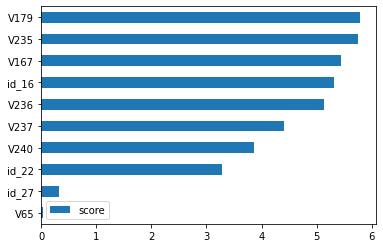

In [47]:
avg_main_features = xgb_main_features[0]
i = 0
for feature_dict in xgb_main_features:
    if i > 0:
        for feature in feature_dict:
            if feature in avg_main_features:
                avg_main_features[feature] += feature_dict[feature]
    i += 1
for feature in avg_main_features:
    avg_main_features[feature] /= len(xgb_main_features)

keys = list(avg_main_features.keys())
values = list(avg_main_features.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data[0:10:].plot(kind='barh')
plt.savefig('XGB_Feature_Imp.jpg', bbox_inches='tight')

### Catboost Training
    The following 2 cells contains the required variables, plotting and K Fold Validation code required to train the CatBoost model. 
    The second code is slightly long as the nature of the prediction is captured in each fold.
    The tuned_param variable is initialized based on the result obtained from hyperparameter optimization of optuna module.

In [48]:
oof_cat = np.zeros(len(xtrain))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
feature_importance_df = pd.DataFrame()
target = 'isFraud'

tuned_param = {'learning_rate': 0.25, 'depth': 8, 'bagging_temperature': 10, 'iterations': 478, 'random_strength': 3.6637673491936444e-06, 'border_count': 12, 'l2_leaf_reg': 18, 'scale_pos_weight': 0.97}
train = xtrain.copy()
train['isFraud'] = ytrain


ROC accuracy: 0.8765260265685603
ROC accuracy: 0.8675981317128515
ROC accuracy: 0.8650971023720508
ROC accuracy: 0.8852234008630148
ROC accuracy: 0.8744612613883667

CV roc score        : 0.8738, std: 0.0071. 
CV accuracy score   : 0.9737, std: 0.0003. 
CV recall score     : 0.3140, std: 0.0108. 
CV precision score  : 0.8360, std: 0.0171. 
CV f1 score         : 0.4563, std: 0.0105.


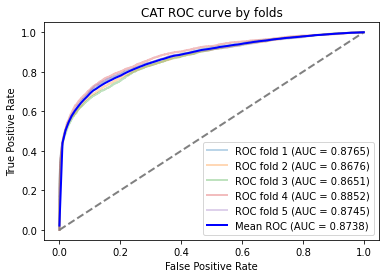

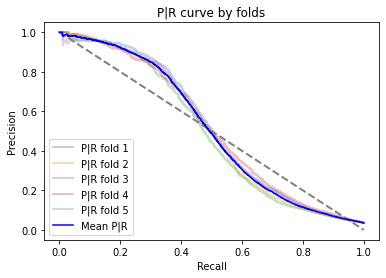

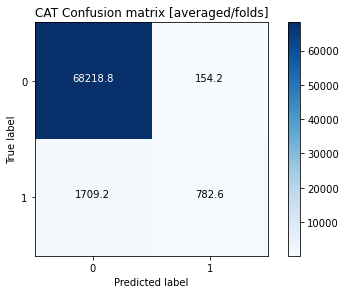

In [49]:
sample_submission = pd.read_csv('../input/frauddetect/sample_submission.csv')
catboost_submission=sample_submission.copy()
catboost_submission['isFraud'] = 0
n_fold = 5
i = 1
folds = KFold(n_splits=n_fold,shuffle=True)
for fold_n, (train_index, valid_index) in enumerate(folds.split(xtrain)):
    
    tuned_model = CatBoostClassifier(task_type = 'GPU', **tuned_param, thread_count = 2, verbose=False)
    
    X_train_, X_valid = xtrain.iloc[train_index], xtrain.iloc[valid_index]
    y_train_, y_valid = ytrain.iloc[train_index], ytrain.iloc[valid_index]
    tuned_model.fit(X_train_,y_train_, cat_features = ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'card4', 'card6', 'DeviceType'])
    
    pred = tuned_model.predict_proba(test)[:,1]
    val = tuned_model.predict_proba(X_valid)[:,1]
    oof_cat[valid_index] = tuned_model.predict_proba(X_valid)[:, 1]
    
    # Scores 
    roc_aucs.append(roc_auc_score(train.iloc[valid_index][target].values, oof_cat[valid_index]))
    accuracies.append(accuracy_score(train.iloc[valid_index][target].values, oof_cat[valid_index].round()))
    recalls.append(recall_score(train.iloc[valid_index][target].values, oof_cat[valid_index].round()))
    precisions.append(precision_score(train.iloc[valid_index][target].values ,oof_cat[valid_index].round()))
    f1_scores.append(f1_score(train.iloc[valid_index][target].values, oof_cat[valid_index].round()))
    
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    catboost_submission['isFraud'] = catboost_submission['isFraud']+pred/n_fold
    del pred
    
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train.iloc[valid_index][target].values, oof_cat[valid_index])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train.iloc[valid_index][target].values, oof_cat[valid_index])
    y_real.append(train.iloc[valid_index][target].values)
    y_proba.append(oof_cat[valid_index])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train.iloc[valid_index][target].values, oof_cat[valid_index].round()))
    
    del X_train_,y_train_
    del tuned_model, X_valid                                                                       
    gc.collect()


# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CAT ROC curve by folds')
plt.legend(loc="lower right")
plt.savefig('ROC_CAT.jpg', bbox_inches='tight')
# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")
plt.savefig('P_R_CAT.jpg', bbox_inches='tight')

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'CAT Confusion matrix [averaged/folds]')
plt.savefig('CM_CAT.jpg', bbox_inches='tight')


In [50]:
submission = pd.read_csv('../input/frauddetect/sample_submission.csv')
submission['isFraud'] = catboost_submission['isFraud']
submission.to_csv('cat_submission.csv', index=False)

### Ensemble
        
        Code to submit an ensemble of 2 models with respecitive weights. 

In [51]:
submission = pd.read_csv('../input/frauddetect/sample_submission.csv')
submission['isFraud'] = 0.8*xgb_submission['isFraud'] + 0.2*catboost_submission['isFraud']
submission.to_csv('ensemble_submit.csv', index=False)

### Post Processing
    Commented because it is conceptual not applicable to the problem. The reason is explained in detail in the report.
Code explanation:
        
    Find out the mean target values for each userid and then for userid's in test, update the prediction of the model with these mean values (along with some weight(higher weight for more importance on userid))

In [52]:
# xtrain['is_train'] = 1
# test['is_train'] = 0
# xtrain['userid'] = user_info_train
# test['userid'] = user_info_test
# xtrain['isFraud'] = ytrain
# test['isFraud'] = xgb_submission['isFraud']
# total_data = pd.concat([xtrain, test], axis = 0)
# total_data['known_fraud'] = total_data.groupby(['userid'])['isFraud'].shift(1)
# test['NewF'] = test['userid'].map(total_data.groupby("userid")['isFraud'].quantile(0.9))

In [53]:
submission = pd.read_csv('../input/frauddetect/sample_submission.csv')
submission['isFraud'] = xgb_submission['isFraud']
submission.to_csv('xgb_prediction.csv', index=False)